<a href="https://colab.research.google.com/github/codeyumm/adl-midterm-project/blob/main/Group_02_Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.9 MB/s eta 0:00:00


In [ ]:
# libs
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import torch.optim as optim
from sklearn.model_selection import KFold

import optuna

In [ ]:
# set random seed for reproducibility
np.random.seed(66)

torch.manual_seed(66)

# select deive, CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Using", device, "for computation.")

Using cuda:0 for computation.


In [ ]:
# get the dataset
train_data = datasets.KMNIST(root="./data", train=True, download=True)

100%|██████████| 18.2M/18.2M [00:13<00:00, 1.39MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 277kB/s]
100%|██████████| 3.04M/3.04M [00:02<00:00, 1.29MB/s]
100%|██████████| 5.12k/5.12k [00:00<00:00, 12.9MB/s]


### Observing the dataset

In [ ]:
# shape of dataset
print(f"Number of training samples : {len(train_data)}")

Number of training samples : 60000


In [ ]:
# display sample image from the test dataset
image, label = train_data[6000]

# size of image
print(f"Size of image is : {image.size}")

Size of image is : (28, 28)


### We can see that we have 28 x 28 image and it is a grayscale as there is only one color channel

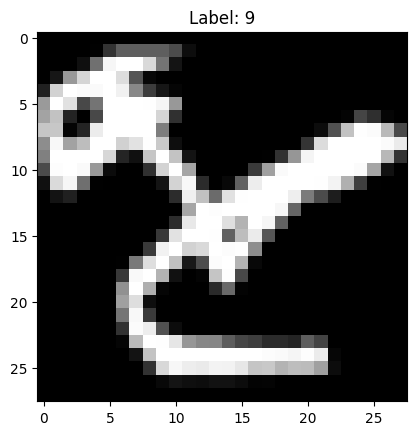

In [ ]:
# sample image
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

### Now we need to normalize the dataset for better computation and also we need to convert it to tensors becasue our deep learning models works with tensors

In [ ]:
# load the dataset
train_data = datasets.KMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())


data_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=False)

# get all pixel values
data = next(iter(data_loader))[0]
mean = data.mean()
std = data.std()

print(f"Mean of train dataset : {mean}")
print(f"STD of train dataset : {std}")


Mean of train dataset : 0.19176216423511505
STD of train dataset : 0.3483428359031677


In [ ]:
# transforms object
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# load the dataset with transforms object to get the normalize data

train_data = datasets.KMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.KMNIST(root="./data", train=False, download=True, transform=transform)


# shape of dataset
print(f"Number of training samples : {len(train_data)}")
print(f"Number of testing samples : {len(test_data)}")

Number of training samples : 60000
Number of testing samples : 10000


### At this point, our input is standardize in terms of we have normalized it wiht mean and std. Now all the pixels are in range of [-1, 1] and most of them should be centerd around 0

### Defining the model architecture

In [ ]:
# model network

class Kmnist_Net(nn.Module):
  def __init__(self):
    super(Kmnist_Net, self).__init__()

    # convert 2d (28 * 28) to 1d 784)

    self.flatten = nn.Flatten()

    # first fully connected layer input(784) to hidden 1 (128)
    self.fc1 = nn.Linear(784, 128)

    # second fully connected layer input(128) to hidden 2 (64)
    self.fc2 = nn.Linear(128, 64)

    # third fully connected layer input(64) to output (10)
    self.fc3 = nn.Linear(64, 10)

    # activation function - for hidden layers - ReLu
    self.relu = nn.ReLU()

    # activation fucntion - for output layer - SoftMax

    # self.soft_max = nn.Softmax()
    # we dont need to add this here because crossentropyloss,
    # expects raw logits as input and it applies logsoftmax

  # forward pass
  def forward(self, input):

    # 2d to 1d
    x = self.flatten(input)

    # pass it to fc1 with ReLu activation
    x = self.fc1(x)
    x = self.relu(x)

    # pass it to fc2 with ReLu activation
    x = self.fc2(x)
    x = self.relu(x)

    # pass it to fc3 with Softmax activation
    x = self.fc3(x)
    # x = self.soft_max(x)

    return x

### In above model we are not adding softmax activation function becasue, CrossEntropyLoss computes the cross entropy loss between input logits and target and it also applies  LogSoftmax internally

### Source - [CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

### Defining Inital Hyperparameters

In [ ]:
# how fast we want to move on gradient to find minima
learning_rate = 0.001

# number of time we want to go thorugh whole dataset
epochs = 50

# number of samples the model sees before updating weights
batch_size = 64

# define loss function - CrossEntropyLoss()
loss_function = nn.CrossEntropyLoss()

In [ ]:
# data loader object to get data into batch
# shuffle True for tranloader becasue it prevents model to remeber the pattern of data
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)

test_loader = DataLoader(test_data, batch_size= 1000, shuffle=False)

### Traning Loooooop

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, loss_function, patience=5):

  # move model to gpu
  model = model.to(device)

  # set model to train
  model.train()

  best_val_acc = 0
  epochs_no_improve = 0


  for epoch in range(epochs):

    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      # get the output
      output = model(images)

      # find the loss
      loss = loss_function(output, labels)

      # backpropogate to find optimal weights
      loss.backward()

      # update weight
      optimizer.step()

      # calculate the loss
      running_loss += loss.item()

      # find correct output
      _, predicted = torch.max(output, 1)

      correct += (predicted == labels).sum().item()

      # total images seen by model
      total += labels.size(0)

    train_acc = ( correct / total ) * 100

    # Validation Accuracy
    val_acc = evaluate_model(model, val_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

  model.load_state_dict(best_model)  # restore best weights
  return model

### Evaluation Loop

In [ ]:
def evaluate_model(model, data_loader):

  correct = 0
  total = 0

  # set model to eval mode
  model.eval()

  # disavle gradient calculations
  torch.no_grad()
  with torch.no_grad():
    for images, labels in data_loader:

        images = images.to(device)
        labels = labels.to(device)

        # get the output
        output = model(images)

        # get the predicted labels
        _, predicted = torch.max(output, 1)

        # total number of images
        total += labels.size(0)

        # count correct predictions
        correct += (predicted == labels).sum().item()


  test_accuracy = 100 * (correct / total)
  print(f"Test Accuracy: {test_accuracy:.2f}%")

  return test_accuracy

### Now we can start creating Hyperparameter Tuning in order to find best hyperparameters.
### We have to compare performance of



*   Adam (Adaptive Moment Estimation)
*   RMSprop (Root Mean Square Prop)
*   AdamW (Adam with Weight Decay)





### 1. Adam
  - For adam below are the parameters that we can adjust
  ### torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, foreach=None, maximize=False, capturable=False, differentiable=False, fused=None, decoupled_weight_decay=False)
  - But we are going to change learning rate only becasue that is the most impactful.

### 2. RMSprop
  - For RMSprop below are the parameters that we can adjust
  ### torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False, capturable=False, foreach=None, maximize=False, differentiable=False)

### 3. AdamW
  - For AdamW below are the parameters that we can adjust
  ### torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, *, maximize=False, foreach=None, capturable=False, differentiable=False, fused=None)
  - Here, we will analyze for different weight decay too.
  

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0, 0.0001, 0.001]  # for AdamW


# combinations

optimizers = {
    'Adam': {'lr': learning_rates},
    'RMSprop': {'lr': learning_rates, 'momentum': [0.0, 0.9] },
    'AdamW': {'lr': learning_rates, 'weight_decay': weight_decays}
}



In [ ]:
import itertools

for optimizer_name, grid in optimizers.items():
  keys = grid.keys()
  values = grid.values()

  for combo in itertools.product(*values):
      param_dict = dict(zip(keys, combo))
      print(f"Optimizer : {optimizer_name}, Params: {param_dict}")

Optimizer : Adam, Params: {'lr': 0.01}
Optimizer : Adam, Params: {'lr': 0.001}
Optimizer : Adam, Params: {'lr': 0.0001}
Optimizer : RMSprop, Params: {'lr': 0.01, 'momentum': 0.0}
Optimizer : RMSprop, Params: {'lr': 0.01, 'momentum': 0.9}
Optimizer : RMSprop, Params: {'lr': 0.001, 'momentum': 0.0}
Optimizer : RMSprop, Params: {'lr': 0.001, 'momentum': 0.9}
Optimizer : RMSprop, Params: {'lr': 0.0001, 'momentum': 0.0}
Optimizer : RMSprop, Params: {'lr': 0.0001, 'momentum': 0.9}
Optimizer : AdamW, Params: {'lr': 0.01, 'weight_decay': 0}
Optimizer : AdamW, Params: {'lr': 0.01, 'weight_decay': 0.0001}
Optimizer : AdamW, Params: {'lr': 0.01, 'weight_decay': 0.001}
Optimizer : AdamW, Params: {'lr': 0.001, 'weight_decay': 0}
Optimizer : AdamW, Params: {'lr': 0.001, 'weight_decay': 0.0001}
Optimizer : AdamW, Params: {'lr': 0.001, 'weight_decay': 0.001}
Optimizer : AdamW, Params: {'lr': 0.0001, 'weight_decay': 0}
Optimizer : AdamW, Params: {'lr': 0.0001, 'weight_decay': 0.0001}
Optimizer : AdamW,

### Cross Validation Loop

In [ ]:
# 5 k-fold
kf = KFold(n_splits=5, shuffle=True, random_state=66)
kf

KFold(n_splits=5, random_state=66, shuffle=True)

In [ ]:
for optimizer_name, grid in optimizers.items():
    keys = grid.keys()
    values = grid.values()

    for combo in itertools.product(*values):
        param_dict = dict(zip(keys, combo))
        fold_accuracies = []
        total_time = 0

        print(f"\nOptimizer: {optimizer_name}, Params: {param_dict}")



Optimizer: Adam, Params: {'lr': 0.01}

Optimizer: Adam, Params: {'lr': 0.001}

Optimizer: Adam, Params: {'lr': 0.0001}

Optimizer: RMSprop, Params: {'lr': 0.01, 'momentum': 0.0}

Optimizer: RMSprop, Params: {'lr': 0.01, 'momentum': 0.9}

Optimizer: RMSprop, Params: {'lr': 0.001, 'momentum': 0.0}

Optimizer: RMSprop, Params: {'lr': 0.001, 'momentum': 0.9}

Optimizer: RMSprop, Params: {'lr': 0.0001, 'momentum': 0.0}

Optimizer: RMSprop, Params: {'lr': 0.0001, 'momentum': 0.9}

Optimizer: AdamW, Params: {'lr': 0.01, 'weight_decay': 0}

Optimizer: AdamW, Params: {'lr': 0.01, 'weight_decay': 0.0001}

Optimizer: AdamW, Params: {'lr': 0.01, 'weight_decay': 0.001}

Optimizer: AdamW, Params: {'lr': 0.001, 'weight_decay': 0}

Optimizer: AdamW, Params: {'lr': 0.001, 'weight_decay': 0.0001}

Optimizer: AdamW, Params: {'lr': 0.001, 'weight_decay': 0.001}

Optimizer: AdamW, Params: {'lr': 0.0001, 'weight_decay': 0}

Optimizer: AdamW, Params: {'lr': 0.0001, 'weight_decay': 0.0001}

Optimizer: AdamW,

In [ ]:
### -- this loop is for grid search

# Cross-validation loop


"""kf = KFold(n_splits=5, shuffle=True, random_state=66)
results = []

for optimizer_name, grid in optimizers.items():
    keys = grid.keys()
    values = grid.values()

    for combo in itertools.product(*values):
        param_dict = dict(zip(keys, combo))
        fold_accuracies = []
        total_time = 0

        print(f"\nOptimizer: {optimizer_name}, Params: {param_dict}")

        for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
            train_subset = torch.utils.data.Subset(train_data, train_idx)
            val_subset = torch.utils.data.Subset(train_data, val_idx)

            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=batch_size)


            # print("Train Loader")
            # print(train_loader)

            model = Kmnist_Net().to(device)

            if optimizer_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=param_dict['lr'])
            elif optimizer_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=param_dict['lr'], momentum=param_dict.get('momentum', 0))
            elif optimizer_name == 'AdamW':
                optimizer = optim.AdamW(model.parameters(), lr=param_dict['lr'], weight_decay=param_dict.get('weight_decay', 0))

            start_time = time.time()
            train_model(model, train_loader, val_loader, optimizer, loss_function)
            elapsed = time.time() - start_time

            acc = evaluate_model(model, val_loader)
            fold_accuracies.append(acc)
            total_time += elapsed

            print(f"Fold {fold+1} Accuracy: {acc:.2f}% | Time: {elapsed:.1f}s")

        avg_acc = np.mean(fold_accuracies)
        avg_time = total_time / 5
        print(f"Average Accuracy: {avg_acc:.2f}%\n")

        results.append({
            'Optimizer': optimizer_name,
            **param_dict,
            'Avg Accuracy': avg_acc,
            'Avg Train Time (s)': avg_time
        })

# Save results
df_results = pd.DataFrame(results)
df_results.to_csv("optimizer_kfold_results.csv", index=False)
print("\nAll results saved to optimizer_kfold_results.csv")"""

'kf = KFold(n_splits=5, shuffle=True, random_state=66)\nresults = []\n\nfor optimizer_name, grid in optimizers.items():\n    keys = grid.keys()\n    values = grid.values()\n\n    for combo in itertools.product(*values):\n        param_dict = dict(zip(keys, combo))\n        fold_accuracies = []\n        total_time = 0\n\n        print(f"\nOptimizer: {optimizer_name}, Params: {param_dict}")\n\n        for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):\n            train_subset = torch.utils.data.Subset(train_data, train_idx)\n            val_subset = torch.utils.data.Subset(train_data, val_idx)\n\n            train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)\n            val_loader = DataLoader(val_subset, batch_size=batch_size)\n\n\n            # print("Train Loader")\n            # print(train_loader)\n\n            model = Kmnist_Net().to(device)\n\n            if optimizer_name == \'Adam\':\n                optimizer = optim.Adam(model.param

In [ ]:
## Optuna Function

def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])

    # sample from your predefined learning rates
    lr = trial.suggest_categorical("lr", [0.01, 0.001, 0.0001])

    # sample optimizer-specific values
    momentum = trial.suggest_categorical("momentum", [0.0, 0.9]) if optimizer_name == "RMSprop" else None
    weight_decay = trial.suggest_categorical("weight_decay", [0, 0.0001, 0.001]) if optimizer_name == "AdamW" else 0

    trial_label = f"[Trial {trial.number}] Optimizer: {optimizer_name}, LR: {lr}"
    if optimizer_name == "RMSprop":
        trial_label += f", Momentum: {momentum}"
    elif optimizer_name == "AdamW":
        trial_label += f", Weight Decay: {weight_decay}"
    print(f"{trial_label} — Starting 5-fold cross-validation")

    #5-fold CV for evaluation
    kf = KFold(n_splits=5, shuffle=True, random_state=66)
    fold_accs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_data)):
        train_subset = Subset(train_data, train_idx)
        val_subset = Subset(train_data, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size)

        model = Kmnist_Net().to(device)

        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        model = train_model(model,train_loader, val_loader, optimizer,loss_function, patience=5)
        acc = evaluate_model(model, val_loader)
        fold_accs.append(acc)

        print(f"Trial {trial.number} | Optimizer: {optimizer_name} | Fold {fold+1} Accuracy: {acc:.2f}%")

    return -np.mean(fold_accs)  # minimize negative accuracy


In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

[I 2025-06-21 14:14:27,661] A new study created in memory with name: no-name-d9664e87-15d4-4316-b49b-1cab16353783


[Trial 0] Optimizer: RMSprop, LR: 0.0001, Momentum: 0.0 — Starting 5-fold cross-validation
Test Accuracy: 84.58%
Epoch [1/50] - Loss: 564.6589 | Train Acc: 79.10% | Val Acc: 84.58%
Test Accuracy: 87.39%
Epoch [2/50] - Loss: 329.2097 | Train Acc: 87.02% | Val Acc: 87.39%
Test Accuracy: 88.65%
Epoch [3/50] - Loss: 268.6552 | Train Acc: 89.44% | Val Acc: 88.65%
Test Accuracy: 90.01%
Epoch [4/50] - Loss: 230.5582 | Train Acc: 90.94% | Val Acc: 90.01%
Test Accuracy: 90.70%
Epoch [5/50] - Loss: 203.1879 | Train Acc: 92.03% | Val Acc: 90.70%
Test Accuracy: 91.52%
Epoch [6/50] - Loss: 182.1912 | Train Acc: 92.94% | Val Acc: 91.52%
Test Accuracy: 92.05%
Epoch [7/50] - Loss: 164.6633 | Train Acc: 93.59% | Val Acc: 92.05%
Test Accuracy: 92.24%
Epoch [8/50] - Loss: 149.4651 | Train Acc: 94.19% | Val Acc: 92.24%
Test Accuracy: 92.77%
Epoch [9/50] - Loss: 137.0231 | Train Acc: 94.72% | Val Acc: 92.77%
Test Accuracy: 93.10%
Epoch [10/50] - Loss: 125.2839 | Train Acc: 95.20% | Val Acc: 93.10%
Test Acc

[I 2025-06-21 14:53:24,722] Trial 0 finished with value: -94.75999999999999 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001, 'momentum': 0.0}. Best is trial 0 with value: -94.75999999999999.


Test Accuracy: 94.77%
Trial 0 | Optimizer: RMSprop | Fold 5 Accuracy: 94.77%
[Trial 1] Optimizer: Adam, LR: 0.0001 — Starting 5-fold cross-validation
Test Accuracy: 84.58%
Epoch [1/50] - Loss: 671.1710 | Train Acc: 75.27% | Val Acc: 84.58%
Test Accuracy: 87.47%
Epoch [2/50] - Loss: 331.4917 | Train Acc: 86.92% | Val Acc: 87.47%
Test Accuracy: 89.02%
Epoch [3/50] - Loss: 267.3283 | Train Acc: 89.48% | Val Acc: 89.02%
Test Accuracy: 90.23%
Epoch [4/50] - Loss: 228.3724 | Train Acc: 90.99% | Val Acc: 90.23%
Test Accuracy: 90.98%
Epoch [5/50] - Loss: 200.1231 | Train Acc: 92.22% | Val Acc: 90.98%
Test Accuracy: 91.68%
Epoch [6/50] - Loss: 177.5043 | Train Acc: 93.14% | Val Acc: 91.68%
Test Accuracy: 92.56%
Epoch [7/50] - Loss: 158.7600 | Train Acc: 93.98% | Val Acc: 92.56%
Test Accuracy: 92.75%
Epoch [8/50] - Loss: 143.5382 | Train Acc: 94.55% | Val Acc: 92.75%
Test Accuracy: 93.19%
Epoch [9/50] - Loss: 130.3870 | Train Acc: 95.12% | Val Acc: 93.19%
Test Accuracy: 93.47%
Epoch [10/50] - Lo

[I 2025-06-21 15:24:35,670] Trial 1 finished with value: -94.85166666666666 and parameters: {'optimizer': 'Adam', 'lr': 0.0001}. Best is trial 1 with value: -94.85166666666666.


Test Accuracy: 94.85%
Trial 1 | Optimizer: Adam | Fold 5 Accuracy: 94.85%
[Trial 2] Optimizer: AdamW, LR: 0.01, Weight Decay: 0 — Starting 5-fold cross-validation
Test Accuracy: 90.43%
Epoch [1/50] - Loss: 339.8887 | Train Acc: 86.65% | Val Acc: 90.43%
Test Accuracy: 90.10%
Epoch [2/50] - Loss: 240.8739 | Train Acc: 91.36% | Val Acc: 90.10%
Test Accuracy: 91.17%
Epoch [3/50] - Loss: 212.4568 | Train Acc: 92.59% | Val Acc: 91.17%
Test Accuracy: 91.22%
Epoch [4/50] - Loss: 190.1064 | Train Acc: 93.43% | Val Acc: 91.22%
Test Accuracy: 91.33%
Epoch [5/50] - Loss: 191.2520 | Train Acc: 93.70% | Val Acc: 91.33%
Test Accuracy: 90.38%
Epoch [6/50] - Loss: 188.2030 | Train Acc: 93.90% | Val Acc: 90.38%
Test Accuracy: 92.13%
Epoch [7/50] - Loss: 167.7275 | Train Acc: 94.35% | Val Acc: 92.13%
Test Accuracy: 92.03%
Epoch [8/50] - Loss: 144.7278 | Train Acc: 94.95% | Val Acc: 92.03%
Test Accuracy: 92.04%
Epoch [9/50] - Loss: 160.3434 | Train Acc: 94.74% | Val Acc: 92.04%
Test Accuracy: 92.17%
Epoch

[I 2025-06-21 15:38:59,613] Trial 2 finished with value: -90.62666666666667 and parameters: {'optimizer': 'AdamW', 'lr': 0.01, 'weight_decay': 0}. Best is trial 1 with value: -94.85166666666666.


Test Accuracy: 91.97%
Trial 2 | Optimizer: AdamW | Fold 5 Accuracy: 91.97%
[Trial 3] Optimizer: Adam, LR: 0.001 — Starting 5-fold cross-validation
Test Accuracy: 91.80%
Epoch [1/50] - Loss: 313.8379 | Train Acc: 87.30% | Val Acc: 91.80%
Test Accuracy: 94.18%
Epoch [2/50] - Loss: 144.6860 | Train Acc: 94.09% | Val Acc: 94.18%
Test Accuracy: 94.79%
Epoch [3/50] - Loss: 96.8641 | Train Acc: 96.09% | Val Acc: 94.79%
Test Accuracy: 94.68%
Epoch [4/50] - Loss: 70.8396 | Train Acc: 97.17% | Val Acc: 94.68%
Test Accuracy: 94.62%
Epoch [5/50] - Loss: 52.1340 | Train Acc: 97.89% | Val Acc: 94.62%
Test Accuracy: 94.66%
Epoch [6/50] - Loss: 43.0937 | Train Acc: 98.13% | Val Acc: 94.66%
Test Accuracy: 94.60%
Epoch [7/50] - Loss: 30.2178 | Train Acc: 98.76% | Val Acc: 94.60%
Test Accuracy: 94.56%
Epoch [8/50] - Loss: 27.8137 | Train Acc: 98.76% | Val Acc: 94.56%
Early stopping triggered after 8 epochs
Test Accuracy: 94.56%
Trial 3 | Optimizer: Adam | Fold 1 Accuracy: 94.56%
Test Accuracy: 91.42%
Epo

[I 2025-06-21 15:54:18,117] Trial 3 finished with value: -94.78833333333333 and parameters: {'optimizer': 'Adam', 'lr': 0.001}. Best is trial 1 with value: -94.85166666666666.


Test Accuracy: 94.31%
Trial 3 | Optimizer: Adam | Fold 5 Accuracy: 94.31%
[Trial 4] Optimizer: Adam, LR: 0.01 — Starting 5-fold cross-validation
Test Accuracy: 90.22%
Epoch [1/50] - Loss: 331.6413 | Train Acc: 86.97% | Val Acc: 90.22%
Test Accuracy: 91.13%
Epoch [2/50] - Loss: 233.5220 | Train Acc: 91.52% | Val Acc: 91.13%
Test Accuracy: 91.11%
Epoch [3/50] - Loss: 208.2300 | Train Acc: 92.64% | Val Acc: 91.11%
Test Accuracy: 91.83%
Epoch [4/50] - Loss: 185.1964 | Train Acc: 93.44% | Val Acc: 91.83%
Test Accuracy: 91.26%
Epoch [5/50] - Loss: 195.5078 | Train Acc: 93.38% | Val Acc: 91.26%
Test Accuracy: 91.88%
Epoch [6/50] - Loss: 184.7033 | Train Acc: 93.88% | Val Acc: 91.88%
Test Accuracy: 91.51%
Epoch [7/50] - Loss: 173.5985 | Train Acc: 94.23% | Val Acc: 91.51%
Test Accuracy: 91.64%
Epoch [8/50] - Loss: 173.3157 | Train Acc: 94.40% | Val Acc: 91.64%
Test Accuracy: 91.38%
Epoch [9/50] - Loss: 168.3707 | Train Acc: 94.52% | Val Acc: 91.38%
Test Accuracy: 91.23%
Epoch [10/50] - Loss: 1

[I 2025-06-21 16:07:55,040] Trial 4 finished with value: -91.55833333333332 and parameters: {'optimizer': 'Adam', 'lr': 0.01}. Best is trial 1 with value: -94.85166666666666.


Test Accuracy: 91.78%
Trial 4 | Optimizer: Adam | Fold 5 Accuracy: 91.78%
[Trial 5] Optimizer: RMSprop, LR: 0.0001, Momentum: 0.9 — Starting 5-fold cross-validation
Test Accuracy: 92.42%
Epoch [1/50] - Loss: 276.3971 | Train Acc: 88.56% | Val Acc: 92.42%
Test Accuracy: 93.81%
Epoch [2/50] - Loss: 129.1127 | Train Acc: 94.80% | Val Acc: 93.81%
Test Accuracy: 94.42%
Epoch [3/50] - Loss: 87.2621 | Train Acc: 96.45% | Val Acc: 94.42%
Test Accuracy: 94.44%
Epoch [4/50] - Loss: 62.7125 | Train Acc: 97.45% | Val Acc: 94.44%
Test Accuracy: 94.92%
Epoch [5/50] - Loss: 45.8689 | Train Acc: 98.03% | Val Acc: 94.92%
Test Accuracy: 94.74%
Epoch [6/50] - Loss: 35.6009 | Train Acc: 98.49% | Val Acc: 94.74%
Test Accuracy: 94.46%
Epoch [7/50] - Loss: 27.5554 | Train Acc: 98.84% | Val Acc: 94.46%
Test Accuracy: 94.72%
Epoch [8/50] - Loss: 23.3926 | Train Acc: 98.94% | Val Acc: 94.72%
Test Accuracy: 94.62%
Epoch [9/50] - Loss: 18.2774 | Train Acc: 99.18% | Val Acc: 94.62%
Test Accuracy: 94.78%
Epoch [10/

[I 2025-06-21 16:23:27,567] Trial 5 finished with value: -94.99666666666667 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001, 'momentum': 0.9}. Best is trial 5 with value: -94.99666666666667.


Test Accuracy: 95.08%
Trial 5 | Optimizer: RMSprop | Fold 5 Accuracy: 95.08%
[Trial 6] Optimizer: Adam, LR: 0.01 — Starting 5-fold cross-validation
Test Accuracy: 88.41%
Epoch [1/50] - Loss: 341.6283 | Train Acc: 86.62% | Val Acc: 88.41%
Test Accuracy: 90.53%
Epoch [2/50] - Loss: 242.5792 | Train Acc: 91.21% | Val Acc: 90.53%
Test Accuracy: 91.60%
Epoch [3/50] - Loss: 219.4932 | Train Acc: 92.26% | Val Acc: 91.60%
Test Accuracy: 91.74%
Epoch [4/50] - Loss: 203.5475 | Train Acc: 92.98% | Val Acc: 91.74%
Test Accuracy: 91.45%
Epoch [5/50] - Loss: 184.5364 | Train Acc: 93.73% | Val Acc: 91.45%
Test Accuracy: 92.13%
Epoch [6/50] - Loss: 183.0910 | Train Acc: 93.81% | Val Acc: 92.13%
Test Accuracy: 92.50%
Epoch [7/50] - Loss: 176.7687 | Train Acc: 94.16% | Val Acc: 92.50%
Test Accuracy: 91.74%
Epoch [8/50] - Loss: 151.2759 | Train Acc: 94.94% | Val Acc: 91.74%
Test Accuracy: 91.22%
Epoch [9/50] - Loss: 174.1606 | Train Acc: 94.43% | Val Acc: 91.22%
Test Accuracy: 92.22%
Epoch [10/50] - Loss

[I 2025-06-21 16:35:33,455] Trial 6 finished with value: -91.53166666666667 and parameters: {'optimizer': 'Adam', 'lr': 0.01}. Best is trial 5 with value: -94.99666666666667.


Test Accuracy: 91.79%
Trial 6 | Optimizer: Adam | Fold 5 Accuracy: 91.79%
[Trial 7] Optimizer: Adam, LR: 0.001 — Starting 5-fold cross-validation
Test Accuracy: 91.67%
Epoch [1/50] - Loss: 311.0886 | Train Acc: 87.38% | Val Acc: 91.67%
Test Accuracy: 93.67%
Epoch [2/50] - Loss: 143.2847 | Train Acc: 94.15% | Val Acc: 93.67%
Test Accuracy: 94.11%
Epoch [3/50] - Loss: 99.1042 | Train Acc: 95.95% | Val Acc: 94.11%
Test Accuracy: 93.97%
Epoch [4/50] - Loss: 70.1492 | Train Acc: 97.17% | Val Acc: 93.97%
Test Accuracy: 94.49%
Epoch [5/50] - Loss: 54.5761 | Train Acc: 97.75% | Val Acc: 94.49%
Test Accuracy: 94.38%
Epoch [6/50] - Loss: 41.3904 | Train Acc: 98.28% | Val Acc: 94.38%
Test Accuracy: 94.85%
Epoch [7/50] - Loss: 33.2127 | Train Acc: 98.61% | Val Acc: 94.85%
Test Accuracy: 94.63%
Epoch [8/50] - Loss: 26.6371 | Train Acc: 98.88% | Val Acc: 94.63%
Test Accuracy: 94.06%
Epoch [9/50] - Loss: 23.1895 | Train Acc: 99.00% | Val Acc: 94.06%
Test Accuracy: 94.92%
Epoch [10/50] - Loss: 21.5692

[I 2025-06-21 16:50:51,073] Trial 7 finished with value: -94.75500000000001 and parameters: {'optimizer': 'Adam', 'lr': 0.001}. Best is trial 5 with value: -94.99666666666667.


Test Accuracy: 94.67%
Trial 7 | Optimizer: Adam | Fold 5 Accuracy: 94.67%
[Trial 8] Optimizer: Adam, LR: 0.0001 — Starting 5-fold cross-validation
Test Accuracy: 84.52%
Epoch [1/50] - Loss: 675.3847 | Train Acc: 75.12% | Val Acc: 84.52%
Test Accuracy: 87.38%
Epoch [2/50] - Loss: 328.6951 | Train Acc: 86.93% | Val Acc: 87.38%
Test Accuracy: 88.89%
Epoch [3/50] - Loss: 265.1082 | Train Acc: 89.41% | Val Acc: 88.89%
Test Accuracy: 90.17%
Epoch [4/50] - Loss: 226.7137 | Train Acc: 90.96% | Val Acc: 90.17%
Test Accuracy: 91.05%
Epoch [5/50] - Loss: 199.7055 | Train Acc: 92.11% | Val Acc: 91.05%
Test Accuracy: 91.46%
Epoch [6/50] - Loss: 178.1786 | Train Acc: 92.99% | Val Acc: 91.46%
Test Accuracy: 92.01%
Epoch [7/50] - Loss: 160.3800 | Train Acc: 93.88% | Val Acc: 92.01%
Test Accuracy: 92.38%
Epoch [8/50] - Loss: 144.7191 | Train Acc: 94.50% | Val Acc: 92.38%
Test Accuracy: 92.79%
Epoch [9/50] - Loss: 130.9921 | Train Acc: 95.03% | Val Acc: 92.79%
Test Accuracy: 93.38%
Epoch [10/50] - Loss:

[I 2025-06-21 17:23:53,318] Trial 8 finished with value: -94.81499999999998 and parameters: {'optimizer': 'Adam', 'lr': 0.0001}. Best is trial 5 with value: -94.99666666666667.


Test Accuracy: 94.79%
Trial 8 | Optimizer: Adam | Fold 5 Accuracy: 94.79%
[Trial 9] Optimizer: RMSprop, LR: 0.01, Momentum: 0.9 — Starting 5-fold cross-validation
Test Accuracy: 9.69%
Epoch [1/50] - Loss: 4347.5413 | Train Acc: 11.33% | Val Acc: 9.69%
Test Accuracy: 10.00%
Epoch [2/50] - Loss: 1927.3584 | Train Acc: 10.02% | Val Acc: 10.00%
Test Accuracy: 10.11%
Epoch [3/50] - Loss: 1769.2097 | Train Acc: 9.79% | Val Acc: 10.11%
Test Accuracy: 9.71%
Epoch [4/50] - Loss: 1733.4086 | Train Acc: 9.93% | Val Acc: 9.71%
Test Accuracy: 9.95%
Epoch [5/50] - Loss: 1733.8035 | Train Acc: 9.96% | Val Acc: 9.95%
Test Accuracy: 10.05%
Epoch [6/50] - Loss: 1734.0294 | Train Acc: 9.83% | Val Acc: 10.05%
Test Accuracy: 10.00%
Epoch [7/50] - Loss: 1733.5283 | Train Acc: 9.77% | Val Acc: 10.00%
Test Accuracy: 10.00%
Epoch [8/50] - Loss: 1733.9859 | Train Acc: 10.08% | Val Acc: 10.00%
Early stopping triggered after 8 epochs
Test Accuracy: 10.00%
Trial 9 | Optimizer: RMSprop | Fold 1 Accuracy: 10.00%
Tes

[I 2025-06-21 17:32:48,836] Trial 9 finished with value: -9.816666666666666 and parameters: {'optimizer': 'RMSprop', 'lr': 0.01, 'momentum': 0.9}. Best is trial 5 with value: -94.99666666666667.


Test Accuracy: 9.28%
Trial 9 | Optimizer: RMSprop | Fold 5 Accuracy: 9.28%
[Trial 10] Optimizer: RMSprop, LR: 0.0001, Momentum: 0.9 — Starting 5-fold cross-validation
Test Accuracy: 92.69%
Epoch [1/50] - Loss: 282.8891 | Train Acc: 88.35% | Val Acc: 92.69%
Test Accuracy: 93.99%
Epoch [2/50] - Loss: 134.3085 | Train Acc: 94.66% | Val Acc: 93.99%
Test Accuracy: 94.61%
Epoch [3/50] - Loss: 91.3225 | Train Acc: 96.28% | Val Acc: 94.61%
Test Accuracy: 95.08%
Epoch [4/50] - Loss: 64.9422 | Train Acc: 97.25% | Val Acc: 95.08%
Test Accuracy: 94.74%
Epoch [5/50] - Loss: 47.9205 | Train Acc: 98.03% | Val Acc: 94.74%
Test Accuracy: 94.70%
Epoch [6/50] - Loss: 35.4409 | Train Acc: 98.47% | Val Acc: 94.70%
Test Accuracy: 94.53%
Epoch [7/50] - Loss: 29.6229 | Train Acc: 98.75% | Val Acc: 94.53%
Test Accuracy: 94.95%
Epoch [8/50] - Loss: 24.6388 | Train Acc: 98.89% | Val Acc: 94.95%
Test Accuracy: 94.83%
Epoch [9/50] - Loss: 20.0887 | Train Acc: 99.13% | Val Acc: 94.83%
Early stopping triggered after

[I 2025-06-21 17:47:55,659] Trial 10 finished with value: -95.05833333333335 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001, 'momentum': 0.9}. Best is trial 10 with value: -95.05833333333335.


Test Accuracy: 95.25%
Trial 10 | Optimizer: RMSprop | Fold 5 Accuracy: 95.25%
[Trial 11] Optimizer: RMSprop, LR: 0.0001, Momentum: 0.9 — Starting 5-fold cross-validation
Test Accuracy: 92.47%
Epoch [1/50] - Loss: 283.3690 | Train Acc: 88.48% | Val Acc: 92.47%
Test Accuracy: 93.38%
Epoch [2/50] - Loss: 135.1938 | Train Acc: 94.54% | Val Acc: 93.38%
Test Accuracy: 94.12%
Epoch [3/50] - Loss: 92.4778 | Train Acc: 96.25% | Val Acc: 94.12%
Test Accuracy: 94.29%
Epoch [4/50] - Loss: 65.7490 | Train Acc: 97.39% | Val Acc: 94.29%
Test Accuracy: 94.56%
Epoch [5/50] - Loss: 50.6367 | Train Acc: 97.86% | Val Acc: 94.56%
Test Accuracy: 94.80%
Epoch [6/50] - Loss: 38.7787 | Train Acc: 98.42% | Val Acc: 94.80%
Test Accuracy: 94.97%
Epoch [7/50] - Loss: 30.4215 | Train Acc: 98.66% | Val Acc: 94.97%
Test Accuracy: 94.89%
Epoch [8/50] - Loss: 24.8215 | Train Acc: 98.91% | Val Acc: 94.89%
Test Accuracy: 94.85%
Epoch [9/50] - Loss: 20.9668 | Train Acc: 99.12% | Val Acc: 94.85%
Test Accuracy: 94.77%
Epoch

[I 2025-06-21 18:01:31,660] Trial 11 finished with value: -94.89 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001, 'momentum': 0.9}. Best is trial 10 with value: -95.05833333333335.


Test Accuracy: 94.94%
Trial 11 | Optimizer: RMSprop | Fold 5 Accuracy: 94.94%
[Trial 12] Optimizer: RMSprop, LR: 0.0001, Momentum: 0.9 — Starting 5-fold cross-validation
Test Accuracy: 92.17%
Epoch [1/50] - Loss: 280.0166 | Train Acc: 88.43% | Val Acc: 92.17%
Test Accuracy: 93.97%
Epoch [2/50] - Loss: 130.9713 | Train Acc: 94.59% | Val Acc: 93.97%
Test Accuracy: 94.04%
Epoch [3/50] - Loss: 89.1754 | Train Acc: 96.40% | Val Acc: 94.04%
Test Accuracy: 94.92%
Epoch [4/50] - Loss: 64.1327 | Train Acc: 97.36% | Val Acc: 94.92%
Test Accuracy: 94.82%
Epoch [5/50] - Loss: 48.4788 | Train Acc: 98.03% | Val Acc: 94.82%
Test Accuracy: 94.67%
Epoch [6/50] - Loss: 35.4825 | Train Acc: 98.53% | Val Acc: 94.67%
Test Accuracy: 94.89%
Epoch [7/50] - Loss: 28.5643 | Train Acc: 98.75% | Val Acc: 94.89%
Test Accuracy: 94.66%
Epoch [8/50] - Loss: 24.6496 | Train Acc: 98.93% | Val Acc: 94.66%
Test Accuracy: 94.76%
Epoch [9/50] - Loss: 19.2437 | Train Acc: 99.15% | Val Acc: 94.76%
Early stopping triggered af

[I 2025-06-21 18:16:35,334] Trial 12 finished with value: -94.98333333333333 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001, 'momentum': 0.9}. Best is trial 10 with value: -95.05833333333335.


Test Accuracy: 95.05%
Trial 12 | Optimizer: RMSprop | Fold 5 Accuracy: 95.05%
[Trial 13] Optimizer: RMSprop, LR: 0.0001, Momentum: 0.9 — Starting 5-fold cross-validation
Test Accuracy: 91.72%
Epoch [1/50] - Loss: 282.6224 | Train Acc: 88.35% | Val Acc: 91.72%
Test Accuracy: 93.35%
Epoch [2/50] - Loss: 136.7852 | Train Acc: 94.52% | Val Acc: 93.35%
Test Accuracy: 94.27%
Epoch [3/50] - Loss: 91.9534 | Train Acc: 96.28% | Val Acc: 94.27%
Test Accuracy: 94.33%
Epoch [4/50] - Loss: 65.7522 | Train Acc: 97.29% | Val Acc: 94.33%
Test Accuracy: 94.62%
Epoch [5/50] - Loss: 46.9537 | Train Acc: 98.01% | Val Acc: 94.62%
Test Accuracy: 94.62%
Epoch [6/50] - Loss: 36.0501 | Train Acc: 98.47% | Val Acc: 94.62%
Test Accuracy: 94.76%
Epoch [7/50] - Loss: 28.5125 | Train Acc: 98.73% | Val Acc: 94.76%
Test Accuracy: 94.65%
Epoch [8/50] - Loss: 23.2757 | Train Acc: 98.98% | Val Acc: 94.65%
Test Accuracy: 94.47%
Epoch [9/50] - Loss: 19.6163 | Train Acc: 99.12% | Val Acc: 94.47%
Test Accuracy: 94.92%
Epoch

[I 2025-06-21 18:32:54,522] Trial 13 finished with value: -95.00666666666666 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001, 'momentum': 0.9}. Best is trial 10 with value: -95.05833333333335.


Test Accuracy: 95.08%
Trial 13 | Optimizer: RMSprop | Fold 5 Accuracy: 95.08%
[Trial 14] Optimizer: AdamW, LR: 0.0001, Weight Decay: 0.001 — Starting 5-fold cross-validation
Test Accuracy: 84.08%
Epoch [1/50] - Loss: 686.4553 | Train Acc: 75.12% | Val Acc: 84.08%
Test Accuracy: 87.34%
Epoch [2/50] - Loss: 333.6386 | Train Acc: 86.79% | Val Acc: 87.34%
Test Accuracy: 89.02%
Epoch [3/50] - Loss: 267.9445 | Train Acc: 89.29% | Val Acc: 89.02%
Test Accuracy: 90.21%
Epoch [4/50] - Loss: 229.2301 | Train Acc: 90.95% | Val Acc: 90.21%
Test Accuracy: 90.96%
Epoch [5/50] - Loss: 202.1827 | Train Acc: 92.04% | Val Acc: 90.96%
Test Accuracy: 91.63%
Epoch [6/50] - Loss: 180.3079 | Train Acc: 93.02% | Val Acc: 91.63%
Test Accuracy: 92.31%
Epoch [7/50] - Loss: 162.9701 | Train Acc: 93.72% | Val Acc: 92.31%
Test Accuracy: 92.50%
Epoch [8/50] - Loss: 147.5108 | Train Acc: 94.33% | Val Acc: 92.50%
Test Accuracy: 92.96%
Epoch [9/50] - Loss: 134.2911 | Train Acc: 94.92% | Val Acc: 92.96%
Test Accuracy: 9

[I 2025-06-21 19:07:04,686] Trial 14 finished with value: -94.85333333333332 and parameters: {'optimizer': 'AdamW', 'lr': 0.0001, 'weight_decay': 0.001}. Best is trial 10 with value: -95.05833333333335.


Test Accuracy: 94.77%
Trial 14 | Optimizer: AdamW | Fold 5 Accuracy: 94.77%


In [ ]:
df = study.trials_dataframe()
df.to_csv("optuna_trials.csv", index=False)